# Домашнее задание: оценить аплифт-эффекта от рекламных предложений

Подобрать оптимальный алгоритм для оценки аплифт-эффекта от рекламных предложений. Наш клиент — французское рекламное агентство criteo. Оно предоставило нам данные о показах рекламы и отклике пользователей на рекламные предложения. Нужно подобрать модель для показа рекламных предложений пользователям. 

#### Описание датасета:
Этот набор данных составлен из данных, полученных в результате нескольких тестов инкрементальности, специальной процедуры рандомизированного эксперимента, в ходе которой случайной части населения не показывается реклама. Он состоит из 25 миллионов строк, каждая из которых представляет пользователя с 11 характеристиками, индикатором воздействия (`treatment`) и 2 метками (посещения (`visit`) и конверсии (`conversion`))

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklift.models import SoloModel, TwoModels
from causalml.inference.meta import BaseSClassifier, BaseTClassifier

# Импортируем X- и R-learner`ы (BaseXClassifier и BaseRClassifier) из библиотеки CausalML
# Нам нужны именно Classifier, так как мы будем решать задачу классификации
# Аналогичные реализации (Regressor) есть и для задач регрессии
from causalml.inference.meta import BaseXClassifier, BaseRClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


In [2]:
df = pd.read_csv('criteo-uplift-v2.1.csv.gz', compression='gzip')
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [6]:
for column in ['treatment', 'conversion', 'visit', 'exposure']:
    print(f'====== {column} ========')
    display(df[column].value_counts())

====== treatment ========


treatment
1    11882655
0     2096937
Name: count, dtype: int64

====== conversion ========


conversion
0    13938818
1       40774
Name: count, dtype: int64

====== visit ========


visit
0    13322663
1      656929
Name: count, dtype: int64

====== exposure ========


exposure
0    13551380
1      428212
Name: count, dtype: int64

Добавим вспогательный признак **target_class** - класс клиента:
* **0 - Control Non-Responders(CN)** 

    Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)
* **1 - Control Responders(CR)**

    Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)
* **2 - Treatment Non-Responders(CN)**

    Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
* **3 - Treatment Responders(CN)** 
    
    Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

In [12]:
df['target_class'] = 0

mask = (df['conversion'] == 1) & (df['treatment'] == 0)
df.loc[mask, 'target_class'] = 1

mask = (df['conversion'] == 0) & (df['treatment'] == 1)
df.loc[mask, 'target_class'] = 2

mask = (df['conversion'] == 1) & (df['treatment'] == 1)
df.loc[mask, 'target_class'] = 3

In [13]:
df['target_class'].value_counts()

target_class
2    11845944
0     2092874
3       36711
1        4063
Name: count, dtype: int64

In [14]:
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure', 'target_class'],
      dtype='object')

In [51]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'visit']
target_col = 'conversion'
treatment_col = 'treatment'

RANDOM_STATE = 13

In [52]:
# Разделим данные на тренировочную, тестовую и валидационную выборки.

df_train, df_test = train_test_split(
    df,
    stratify=df[[treatment_col, target_col]],
    random_state=RANDOM_STATE,
    test_size=0.3
)

# Теперь разделим тренировочную выборку на обучающую и валидационную
df_train, df_val = train_test_split(
    df_train,
    stratify=df_train[[treatment_col, target_col]],
    random_state=RANDOM_STATE,
    test_size=0.2  # например, 20% от тренировочных данных
)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

# сохраним выборки для использования в разных моделях
df_train_original = df_train.copy()
df_test_original = df_test.copy()
df_val_original = df_val.copy()

df_train.head()

(7828571, 17)
(4193878, 17)
(1957143, 17)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,target_class
1481464,16.032043,10.059654,8.314677,3.907662,10.280525,4.115453,-1.288207,4.833815,3.882650,29.642144,5.300375,-0.168679,1,0,1,0,2
3054389,15.984669,10.059654,8.214383,3.359763,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2
12587140,25.511648,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,0,0,0,0,0
11587459,12.616365,10.059654,8.424867,4.679882,10.280525,4.115453,0.294443,4.833815,3.876391,20.050937,5.300375,-0.168679,1,0,0,0,2
527221,25.964665,10.059654,8.214383,4.679882,10.280525,4.115453,-3.993764,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0,2


In [53]:
# Создадим функцию для построения qini-curve и расчета qini-score.

def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)

    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)

    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

## S-learner

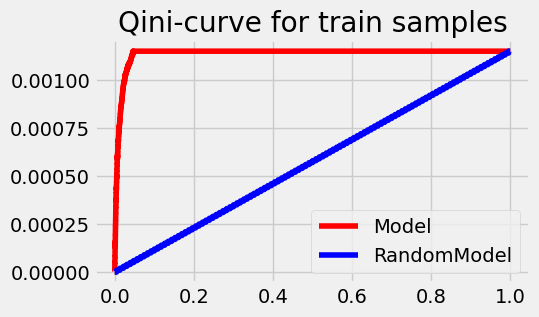

Qini score: 4403.893


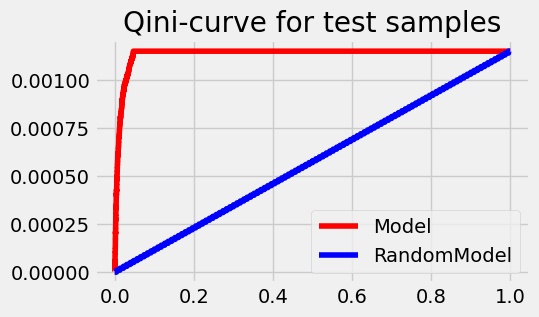

Qini score: 2353.612


In [54]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создаем базовый S-learner
s_learner = SoloModel(estimator=LogisticRegression(max_iter=10000))

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
s_learner = s_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train)
qini_df(df_test, title='test')


#### Выводы

* Разница между Qini score на тренировочной и тестовой выборках (4403.893 против 2353.612) может указывать на переобучение модели

* Несмотря на это, модель показывает неплохие результаты и на тестовой выборке. Qini-кривая тестовой выборки значительно выше случайной модели, что подтверждает, что модель способна выявлять позитивный uplift-эффект.

## T-learner

/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


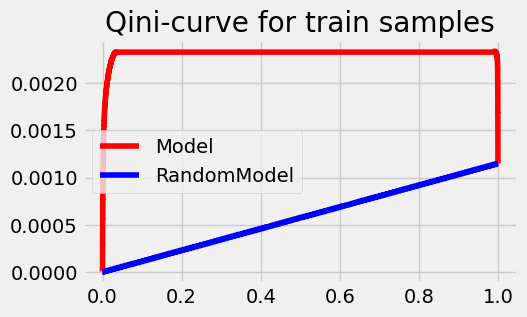

Qini score: 13647.344


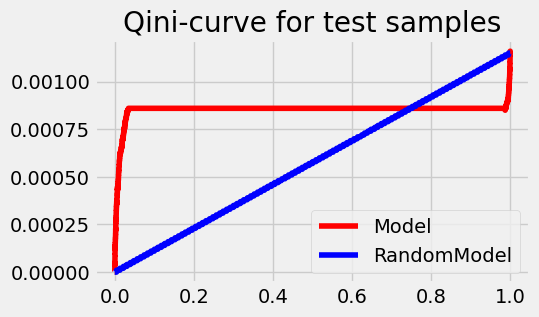

Qini score: 1162.894


In [58]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0),
    estimator_ctrl=CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0)
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
t_learner = t_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта
uplift_vals = t_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта
uplift_vals = t_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

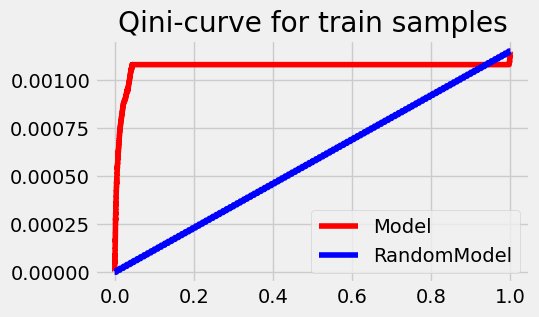

Qini score: 3855.692


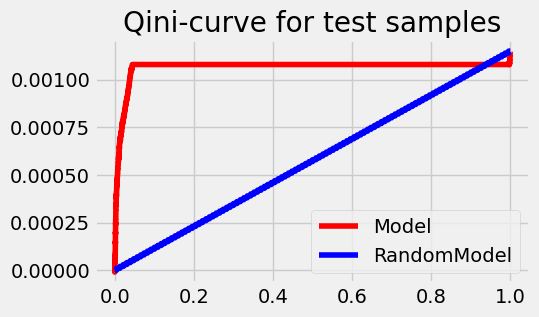

Qini score: 2057.314


In [60]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создадим базовый T-learner
t_learner = TwoModels(
    estimator_trmnt=LogisticRegression(max_iter=10000),
    estimator_ctrl=LogisticRegression(max_iter=10000)
)

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
t_learner = t_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта
uplift_vals = t_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта
uplift_vals = t_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

#### Выводы
* версия T-learner с LogisticRegression в качестве базовой модели показывает меньший разброс между Qini score между тренировочной и тествовой выборками по сравнению с базовой моделью CatBoostClassifier

* наблюдается переобучение модели, хотя и в меньше степени по сравнению с S-learner

## X-learner

/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

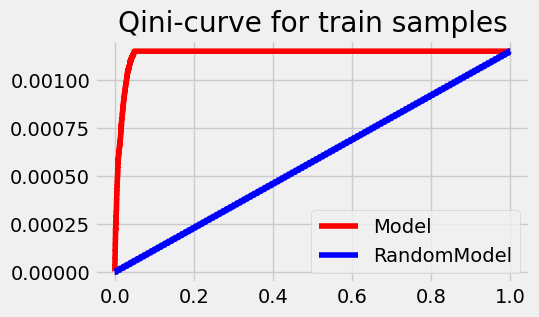

Qini score: 4381.036


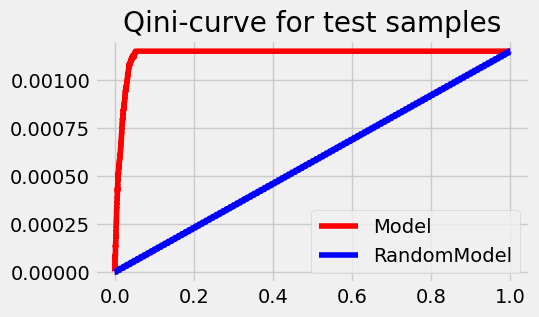

Qini score: 2339.144


In [61]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создадим базовый X-learner
x_learner = BaseXClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=13, verbose=0),
    effect_learner=LinearRegression()
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(
    X=df_train[feature_cols],
    treatment=df_train[treatment_col],
    y=df_train[target_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

## R-learner

/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/moskalen/anaconda3/envs/pymc3_virt/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

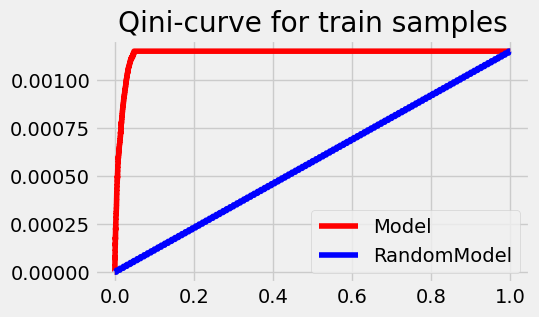

Qini score: 4382.714


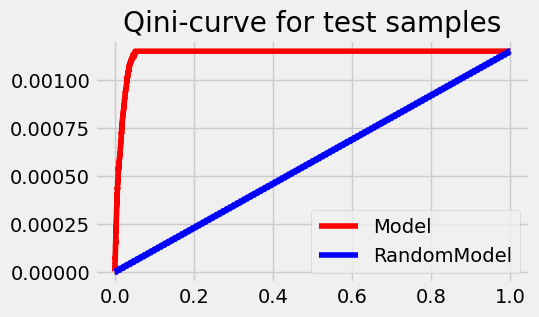

Qini score: 2340.186


In [62]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создадим базовый R-learner
r_learner = BaseRClassifier(
    outcome_learner=CatBoostClassifier(depth=5, random_seed=13, verbose=0),
    effect_learner=LinearRegression(),
    random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

## UpliftRandomForest

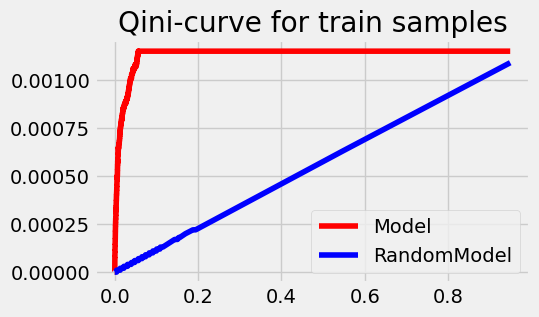

Qini score: 4361.646


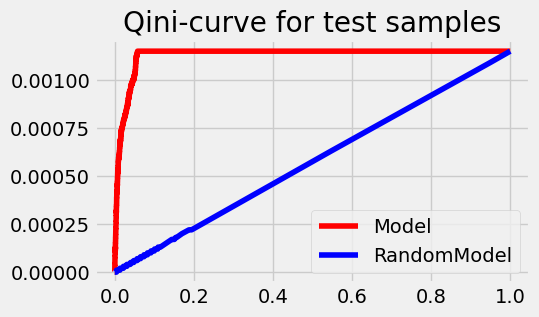

Qini score: 2322.388


In [72]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создаем простое дерево.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=100,
    min_samples_treatment=50,
    n_reg=100,
    evaluationFunction='ED',
    control_name='0',
    random_state=RANDOM_STATE,
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
uplift_forest.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = uplift_forest.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_forest.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

### Выводы

|Model|Base Model(s)|Qini Score (train)|Qini Score (test)|Diff|
|--|--|--|--|--|
|S-learner|LogisticRegression|4403.893|2353.612|2050.281|
|T-learner|CatBoostClassifier|13647.344|1162.894|12484.45|
|T-learner|LogisticRegression|3855.692|2057.314|1798.378|
|X-learner|CatBoostClassifier/LinearRegression|4381.036|2339.144|2041.892|
|R-learner|CatBoostClassifier/LinearRegression|4382.714|2340.186|2042.528|
|UpliftRandomForestClassifier||4361.646|2322.388|2039.258|

* `S-learner (LogisticRegression)`, `X-learner (CatBoost/LinearRegression)`, `R-learner (CatBoost/LinearRegression)` и `UpliftRandomForestClassifier` демонстрируют наиболее сбалансированные результаты, с хорошей обобщающей способностью и приемлемыми Qini score на тестовой выборке.
    
    Эти модели могут быть использованы в данном бизнес-кейсе, особенно если важна стабильность и избегание переобучения, но наилучший результат в Qini Score на тестовой выборке показала модель `S-learner (LogisticRegression)` (2353.612)

* `T-learner с CatBoostClassifier` показала значительное переобучение, и её лучше избегать для этого кейса, несмотря на высокий результат на тренировочной выборке.





### Дополнение

Проверим, можно ли улучшить модель `S-learner` подобрав лучшие гипер-параметры для базовой модели `LogisticRegression`

Fitting 5 folds for each of 24 candidates, totalling 120 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Лучшие параметры: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


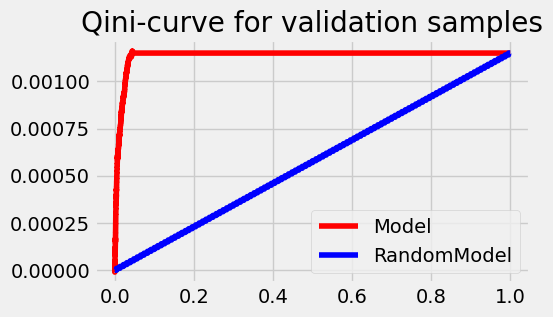

Qini score: 1099.592


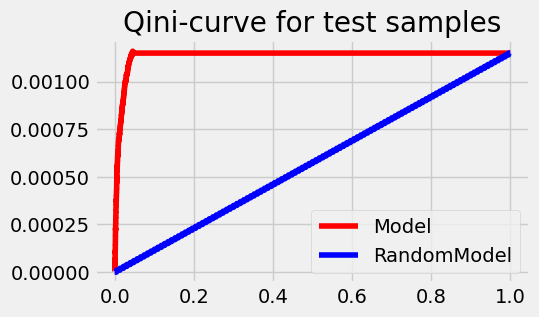

Qini score: 2355.303


In [75]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()
df_val = df_val_original.copy()

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Определим сетку гиперпараметров для Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Создадим объект LogisticRegression
log_reg = LogisticRegression(max_iter=10000)

# Создадим GridSearchCV для подбора гиперпараметров на тренировочных данных
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Выполним подбор гиперпараметров на тренировочных данных
grid_search.fit(df_train[feature_cols], df_train[target_col])

# Получаем лучшие параметры
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

# Теперь обучаем модель на полной тренировочной выборке с лучшими параметрами
s_learner = SoloModel(estimator=LogisticRegression(**best_params, max_iter=10000))
s_learner.fit(X=df_train[feature_cols], y=df_train[target_col], treatment=df_train[treatment_col])

# Оцениваем на валидационной выборке
uplift_vals_val = s_learner.predict(df_val[feature_cols])
df_val['uplift_score'] = uplift_vals_val
qini_df(df_val, title='validation')

# После оценки на валидационной выборке, обучаем модель на полной тренировочной выборке и тестируем на df_test
s_learner.fit(X=df_train[feature_cols], y=df_train[target_col], treatment=df_train[treatment_col])

# Оцениваем на тестовой выборке
uplift_vals_test = s_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals_test
qini_df(df_test, title='test')

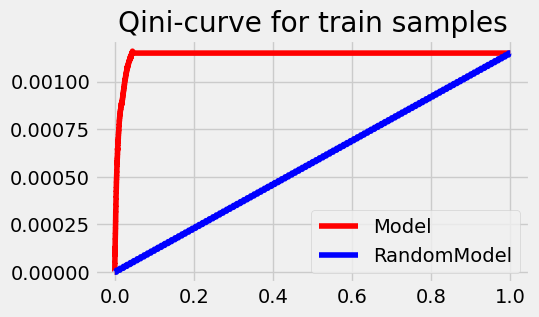

Qini score: 4407.977


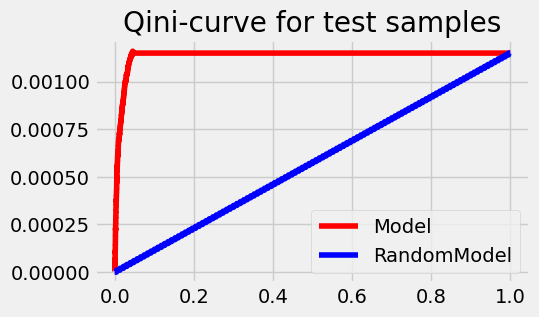

Qini score: 2355.303


In [76]:
df_train = df_train_original.copy()
df_test = df_test_original.copy()

# Создаем базовый S-learner
# 'C': 100, 'penalty': 'l2', 'solver': 'liblinear'
s_learner = SoloModel(estimator=LogisticRegression(max_iter=10000, C=100, penalty='l2', solver='liblinear'))

# Для обучения нам нужны датафрем с факторами, таргет и колонка с фактом воздействия
s_learner = s_learner.fit(
    X=df_train[feature_cols],
    y=df_train[target_col],
    treatment=df_train[treatment_col]
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(df_train[feature_cols])
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# посмотрим на qini score
qini_df(df_train)
qini_df(df_test, title='test')


In [77]:
best_params

{'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}

### Выводы
* с помощью подбора гиперпараметров для базовой модели LogisticRegression удалось немного улучшить Qini score метрику для модели S-learner c 2353.612 до 2355.303